In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Task description

We had several measurements (MFL) of the pipe defects.

Each measurement has 3 channels.

Each measurement (defect) belongs to one of two defect location ( internal and external , or ID and OD).
Also, each defect belongs to different sub-type (i.e, corrosion, dent, gouge, etc.)

Candidate should:

1. Perform EDA. Draw conclusions.
2. On the basis of provided data, train classifier that will predict defect location for unlabeled data.
Scoring - F1. Goal is to get F1 >0.8
3. Perform unsupervised clustering. 
Identify optimal number of clusters.
Draw most typical representative of each identified class.

# Solution:

## 1) EDA + Feature engineering

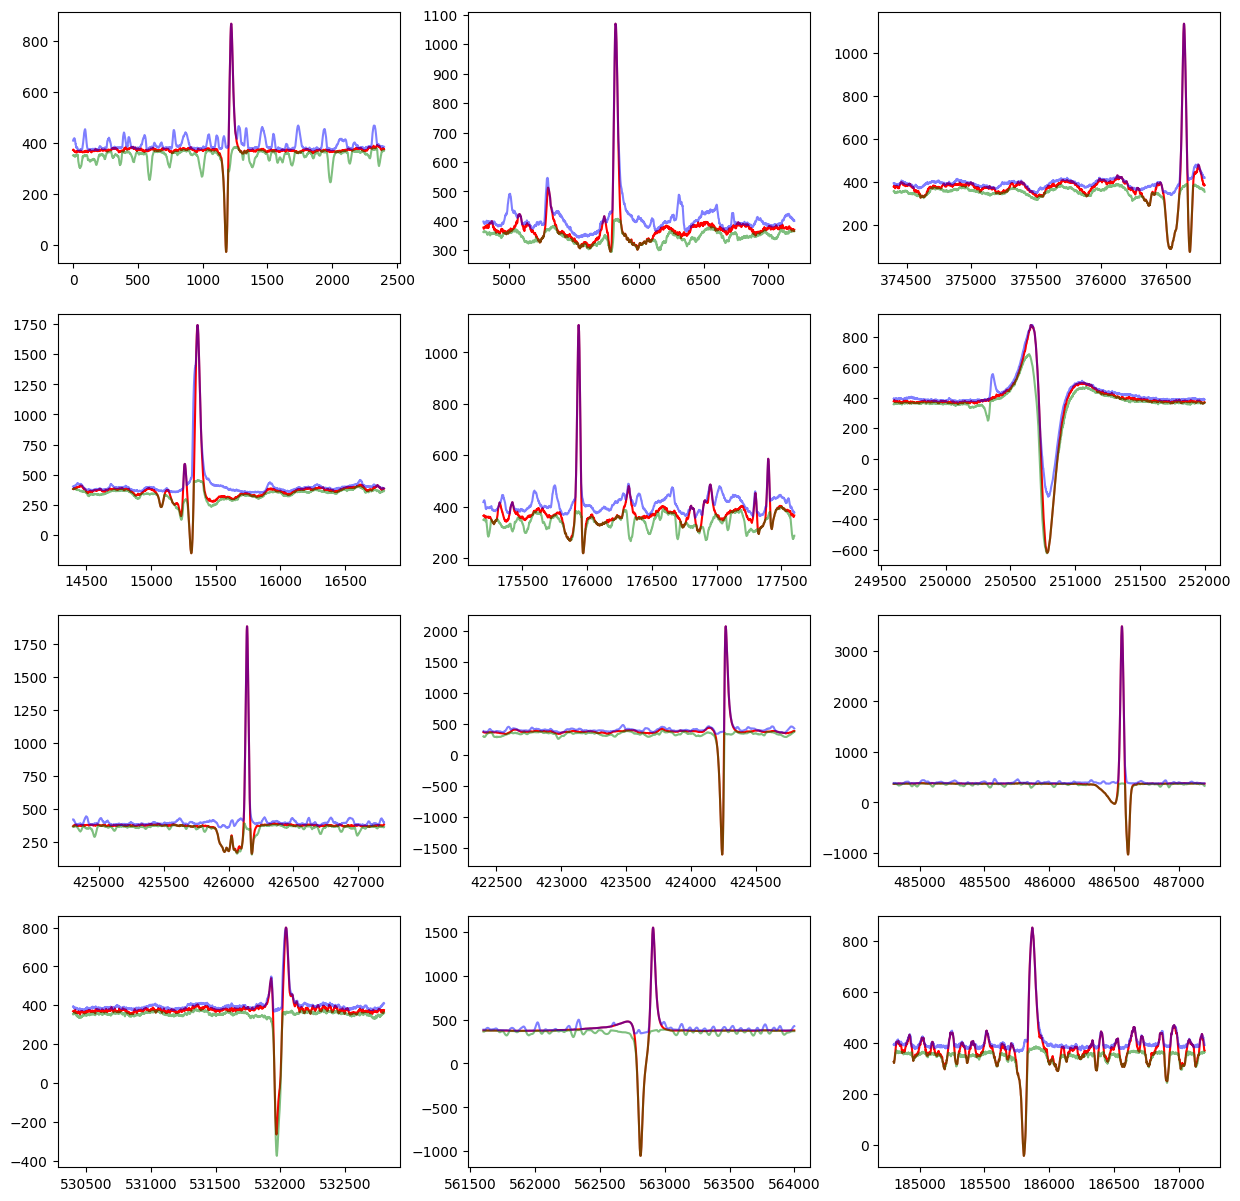

In [326]:
### VISUALIZE SOME SAMPLES ###

# Loading data
data = pd.read_csv('data.csv')
target_train = pd.read_csv('target_train.csv')

# Secluding X's according to 'target_train'
raw_samples = data[data['id'].isin(target_train['id'])]
raw_samples.to_csv('raw_samples.csv', index=False)

# Draw
ID = ['1_1','4_1','6_2','8_1','105_1','160_1','41_2','37_2','80_2','111_2','144_2','109_1']
samples = [raw_samples[raw_samples['id']==pid] for pid in ID]

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i, ax in enumerate( axs.flat):
    ax.plot(samples[i]['ch0'], c='r', alpha=1, label='ch0')
    ax.plot(samples[i]['ch1'], c='g', alpha=0.5, label='ch1')
    ax.plot(samples[i]['ch2'], c='b', alpha=0.5, label='ch2')

Conclusion: Data is represented as time series. Time series could be classified by a simple linear model. To do so, data should be characterized by descriptive features. Below will be generated statistical, frequency and peak features for each channel to work with and to pass to a model.

In [104]:
#Functions that create meaningful features
def extract_statistical_features(channel):
    features = {}
    features['mean'] = np.mean(channel)
    features['std_dev'] = np.std(channel)
    features['min'] = np.min(channel)
    features['max'] = np.max(channel)
    features['range'] = features['max'] - features['min']
    features['skewness'] = pd.Series(channel).skew()
    features['kurtosis'] = pd.Series(channel).kurt()
    return features

def extract_frequency_features(channel):
    fft_values = fft(channel)
    fft_magnitude = np.abs(fft_values)  # Get magnitude
    features = {}
    features['fft_mean'] = np.mean(fft_magnitude)
    features['fft_std_dev'] = np.std(fft_magnitude)
    features['fft_max'] = np.max(fft_magnitude)
    features['fft_peak_freq'] = np.argmax(fft_magnitude)  # Frequency of the largest peak
    return features

def extract_peak_features(channel):
    peaks, _ = find_peaks(channel)
    valleys, _ = find_peaks(-channel)
    features = {}
    features['num_peaks'] = len(peaks)
    features['num_valleys'] = len(valleys)
    if len(peaks) > 0:
        features['max_peak_height'] = max(channel[peaks])
    else:
        features['max_peak_height'] = 0
    if len(valleys) > 0:
        features['min_valley_depth'] = min(channel[valleys])
    else:
        features['min_valley_depth'] = 0
    return features

def channel_new_features(channel):
    stat = extract_statistical_features(channel)
    freq = extract_frequency_features(channel)
    peak = extract_peak_features(channel)
    channel_new_features = list(stat.values()) + list(freq.values()) + list(peak.values())
    return channel_new_features

# 'OD' class is 0
# 'ID' class is 1
def sample_new_features(sample_ID, target_train):
    sample = raw_samples[raw_samples['id']==sample_ID]
    ch0 = np.array(sample['ch0'])
    ch1 = np.array(sample['ch1'])
    ch2 = np.array(sample['ch2'])
    ch0_new_features = channel_new_features(ch0)
    ch1_new_features = channel_new_features(ch1)
    ch2_new_features = channel_new_features(ch2)
    if target_train[target_train['id']==sample_ID]['target'].values[0] == 'ID':
        label = [1]
    else: label = [0]
    sample_new_features = np.array(ch0_new_features + ch1_new_features + ch2_new_features + label)
    return sample_new_features

def sample_new_features_nolabels(sample_ID, unlabeled_data):
    sample = unlabeled_data[unlabeled_data['id']==sample_ID]
    ch0 = np.array(sample['ch0'])
    ch1 = np.array(sample['ch1'])
    ch2 = np.array(sample['ch2'])
    ch0_new_features = channel_new_features(ch0)
    ch1_new_features = channel_new_features(ch1)
    ch2_new_features = channel_new_features(ch2)
    sample_new_features = np.array(ch0_new_features + ch1_new_features + ch2_new_features + [sample_ID])
    return sample_new_features

def name_columns(data, last_column):
    data.columns = [    'ch0_mean', 'ch0_std_dev', 'ch0_min', 'ch0_max', 'ch0_range', 'ch0_skewness', 'ch0_kurtosis',\
                        'ch0_fft_mean', 'ch0_fft_std_dev', 'ch0_fft_max', 'ch0_fft_peak_freq',\
                        'ch0_num_peaks', 'ch0_num_valleys', 'ch0_max_peak_height', 'ch0_min_valley_depth',\
                            
                        'ch1_mean', 'ch1_std_dev', 'ch1_min', 'ch1_max', 'ch1_range', 'ch1_skewness', 'ch1_kurtosis',\
                        'ch1_fft_mean', 'ch1_fft_std_dev', 'ch1_fft_max', 'ch1_fft_peak_freq',\
                        'ch1_num_peaks', 'ch1_num_valleys', 'ch1_max_peak_height', 'ch1_min_valley_depth',\
                            
                        'ch2_mean', 'ch2_std_dev', 'ch2_min', 'ch2_max', 'ch2_range', 'ch2_skewness', 'ch2_kurtosis',\
                        'ch2_fft_mean', 'ch2_fft_std_dev', 'ch2_fft_max', 'ch2_fft_peak_freq',\
                        'ch2_num_peaks', 'ch2_num_valleys', 'ch2_max_peak_height', 'ch2_min_valley_depth', last_column,\
                        ]
    

def name_columns_45(data):
    data.columns = [    'ch0_mean', 'ch0_std_dev', 'ch0_min', 'ch0_max', 'ch0_range', 'ch0_skewness', 'ch0_kurtosis',\
                        'ch0_fft_mean', 'ch0_fft_std_dev', 'ch0_fft_max', 'ch0_fft_peak_freq',\
                        'ch0_num_peaks', 'ch0_num_valleys', 'ch0_max_peak_height', 'ch0_min_valley_depth',\
                            
                        'ch1_mean', 'ch1_std_dev', 'ch1_min', 'ch1_max', 'ch1_range', 'ch1_skewness', 'ch1_kurtosis',\
                        'ch1_fft_mean', 'ch1_fft_std_dev', 'ch1_fft_max', 'ch1_fft_peak_freq',\
                        'ch1_num_peaks', 'ch1_num_valleys', 'ch1_max_peak_height', 'ch1_min_valley_depth',\
                            
                        'ch2_mean', 'ch2_std_dev', 'ch2_min', 'ch2_max', 'ch2_range', 'ch2_skewness', 'ch2_kurtosis',\
                        'ch2_fft_mean', 'ch2_fft_std_dev', 'ch2_fft_max', 'ch2_fft_peak_freq',\
                        'ch2_num_peaks', 'ch2_num_valleys', 'ch2_max_peak_height', 'ch2_min_valley_depth',\
                        ]

In [5]:
# Creating dataset with meaningful features
dataset_clean = np.empty((0, 46))
target_train = pd.read_csv('target_train.csv')

for sample_ID in raw_samples['id'].unique():
    dataset_clean = np.vstack([dataset_clean, sample_new_features(sample_ID, target_train)])

dataset_clean_pd = pd.DataFrame(dataset_clean)
name_columns( dataset_clean_pd, 'label')

dataset_clean_pd.to_csv('dataset_clean.csv', index=False)
dataset_clean_pd

,ch0_mean,ch0_std_dev,ch0_min,ch0_max,ch0_range,ch0_skewness,ch0_kurtosis,ch0_fft_mean,ch0_fft_std_dev,ch0_fft_max,...,ch2_kurtosis,ch2_fft_mean,ch2_fft_std_dev,ch2_fft_max,ch2_fft_peak_freq,ch2_num_peaks,ch2_num_valleys,ch2_max_peak_height,ch2_min_valley_depth,label
0,372.823823,59.442505,-27.284988,866.018051,893.303039,2.156090,38.461237,1009.267683,18467.696487,894777.175667,...,46.918105,990.351975,19672.212492,9.577438e+05,0.0,314.0,313.0,866.018051,370.403059,0.0
1,375.149900,77.344105,295.275900,1069.721045,774.445145,6.277170,46.268748,1180.988287,18727.845716,900359.759009,...,41.300220,1207.711765,20419.434044,9.858436e+05,0.0,428.0,428.0,1069.721045,342.370537,0.0
2,374.982172,168.272847,-151.375620,1742.501576,1893.877196,5.247763,36.703664,1949.771564,20040.561444,899957.211991,...,35.619476,1959.493692,22168.786212,1.012324e+06,0.0,406.0,406.0,1742.501576,350.967177,0.0
3,373.964124,50.742319,26.163687,794.628561,768.464874,2.052328,38.710235,922.852840,18465.259816,897513.897362,...,48.430578,902.846493,19593.436209,9.557558e+05,0.0,322.0,322.0,794.628561,368.907991,0.0
4,373.030329,29.345717,141.283912,652.223348,510.939437,2.262554,51.486635,781.699750,18314.465874,895272.790659,...,26.080038,790.693192,19385.728995,9.479085e+05,0.0,347.0,348.0,652.223348,370.776826,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,372.790496,182.165909,-1152.697310,1640.089429,2792.786739,-1.944782,39.568364,2415.291921,20182.754467,894697.189537,...,74.211898,1895.696755,20677.316164,9.802625e+05,0.0,350.0,351.0,1640.089429,344.239372,0.0
96,373.316417,212.019916,-1053.275298,1547.395222,2600.670520,-1.733684,23.128417,2066.673508,20930.625439,895959.400567,...,50.024992,1647.783898,21223.747544,9.994409e+05,0.0,99.0,99.0,1547.395222,342.744304,0.0
97,374.059590,330.607786,-5815.440159,739.311050,6554.751210,-13.899094,215.603396,7014.233200,23429.330711,897743.016509,...,11.096189,972.108184,20334.474950,9.856900e+05,0.0,381.0,382.0,739.311050,366.291623,0.0
98,370.578730,52.999570,192.116218,483.280682,291.164463,-1.411352,2.449415,841.552759,18319.986549,889388.951145,...,0.382229,647.414837,20028.294193,9.801627e+05,0.0,444.0,445.0,483.280682,354.704847,1.0


## 2) Train classifier

The model of choice is LinearSVC since Logreg model isn't as capable to bend a hyperplane under such a number of features.

In [6]:
# Model init, build and apply
X = dataset_clean_pd.iloc[:,:-1]
y = dataset_clean_pd.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
linear_svm = LinearSVC().fit(X_train,y_train)
y_pred = linear_svm.predict(X_test)
print('Train accuracy: {}'.format(linear_svm.score(X_train, y_train)))
print('Test accuracy: {}'.format(linear_svm.score(X_test, y_test)))
print('f1: {}'.format(f1_score(y_test, y_pred)))

Train accuracy: 0.92
Test accuracy: 0.96
f1: 0.9411764705882353


Predicting unlabeled samples (just in case)

In [319]:
# Getting unlabeled samples
unlabeled_data = data[~data['id'].isin(target_train['id'])]
unlabeled_data_clean = np.empty((0, 46))

for sample_ID in unlabeled_data['id'].unique():
    unlabeled_data_clean = np.vstack([unlabeled_data_clean, sample_new_features_nolabels(sample_ID, unlabeled_data)])

unlabeled_data_clean_pd = pd.DataFrame(unlabeled_data_clean)
name_columns( unlabeled_data_clean_pd, 'id')

unlabeled_data_clean_pd.to_csv('unlabeled_data_clean.csv', index=False)
unlabeled_data_clean_pd


# Model apply
X = unlabeled_data_clean_pd.iloc[:,:-1]
y_pred = linear_svm.predict(X)

y_pred_litera = np.where(y_pred == 0, 'OD', 'ID')
names = unlabeled_data_clean_pd.iloc[:,-1].values
rest_pd = pd.DataFrame(np.column_stack((names, y_pred_litera)))
rest_pd.columns = ['ID', 'Type']
rest_pd.to_csv('rest.csv', index=False)
rest_pd

,ID,Type
0,2_1,OD
1,5_1,OD
2,6_1,OD
3,7_1,OD
4,9_1,OD
...,...,...
140,147_2,OD
141,148_2,OD
142,175_2,ID
143,207_2,ID


Resulted predictions are written into 'rest.scv'

## 3) Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS

# Printing resulting info
def clustering_info(data, method):
    data['Cluster'] = method
    silhouette_avg = silhouette_score(data, method)
    print( 'silhouette_avg: ', silhouette_avg)
    print( data['Cluster'].value_counts())

Preparing data:

In [ ]:
# Getting all the samples
all_data = data[:]
all_data_clean = np.empty((0, 46))

for sample_ID in all_data['id'].unique():
    all_data_clean = np.vstack([all_data_clean, sample_new_features_nolabels(sample_ID, all_data)])

all_data_clean_pd = pd.DataFrame(all_data_clean)
name_columns( all_data_clean_pd, 'id')
all_data_clean_pd.to_csv('all_data_clean_ids.csv', index=False)
all_data_clean_pd = all_data_clean_pd.drop(all_data_clean_pd.columns[-1], axis=1)

# Normalizing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_data_clean_pd)
scaled_data = pd.DataFrame(scaled_data)
name_columns_45(scaled_data)
scaled_data.to_csv('scaled_data.csv', index=False)
scaled_data

,ch0_mean,ch0_std_dev,ch0_min,ch0_max,ch0_range,ch0_skewness,ch0_kurtosis,ch0_fft_mean,ch0_fft_std_dev,ch0_fft_max,...,ch2_skewness,ch2_kurtosis,ch2_fft_mean,ch2_fft_std_dev,ch2_fft_max,ch2_fft_peak_freq,ch2_num_peaks,ch2_num_valleys,ch2_max_peak_height,ch2_min_valley_depth
0,-0.199730,-0.581660,0.276642,-0.338948,-0.362162,0.280917,0.138287,-0.488963,-0.477094,-0.199730,...,0.478747,0.402683,-0.443858,-0.705682,-0.784633,0.0,-0.279925,-0.288592,-0.338881,0.424866
1,-0.000596,-0.205053,0.060485,0.053996,-0.015933,0.262197,0.082388,-0.216947,-0.307232,-0.000596,...,0.915461,0.855044,-0.064766,-0.465912,-0.545554,0.0,-0.205497,-0.214149,0.054052,0.353448
2,0.425248,-0.407486,0.572744,-0.072255,-0.438995,1.324070,0.325788,-0.354006,-0.368172,0.425248,...,0.380452,0.212275,-0.167055,-0.292234,-0.207768,0.0,0.662835,0.662635,-0.072195,-0.021498
3,0.111545,-0.337656,0.469469,-0.000811,-0.330994,1.200164,0.234262,-0.318372,-0.361694,0.111545,...,0.362079,0.116599,-0.145619,-0.298675,-0.312192,0.0,0.811692,0.811523,-0.000753,0.085629
4,-0.775207,-0.341368,0.384378,-0.098680,-0.319397,0.883063,-0.020891,-0.331146,-0.429145,-0.775207,...,0.571355,0.312936,-0.243451,-0.553088,-0.698141,0.0,0.985359,0.993497,-0.098619,0.055871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,-1.707108,-0.557079,0.415601,-0.849823,-0.712258,-0.603907,-0.726750,-0.572535,-0.580082,-1.707108,...,-1.618917,-1.198123,-0.839834,-0.735003,-0.762949,0.0,-1.859463,-1.860186,-0.849743,-0.325026
241,-0.802949,-0.644347,0.478046,-0.840036,-0.751399,-0.622096,-0.726556,-0.620773,-0.538938,-0.802949,...,-1.552557,-1.174563,-0.880579,-0.508657,-0.324392,0.0,0.795152,0.803251,-0.839956,0.174902
242,0.857367,-0.684161,0.400847,-0.835632,-0.694862,-1.111965,-0.437374,-0.702394,-0.422728,0.857367,...,-1.138259,-1.052849,-0.963897,-0.764914,-0.785262,0.0,0.513978,0.513747,-0.835552,0.228466
243,-0.236260,-0.195889,0.328795,-0.131466,-0.296444,0.502867,-0.295700,-0.300443,-0.316648,-0.236260,...,0.402453,0.069366,-0.223401,-0.226758,-0.125413,0.0,0.952279,0.952139,-0.131404,0.174902


Looking for the best clusterizer:

NOTE: All my approaches struggle with secluding meaningful clusters so I decided to go with 'silhouette_score' metric to have something.

In [ ]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
clustering_info(scaled_data, clusters)

silhouette_avg:  0.48564825262851474
Cluster
1    208
0     19
2     18
Name: count, dtype: int64


In [221]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=1)
clusters = dbscan.fit_predict(scaled_data)
clustering_info(scaled_data, clusters)

silhouette_avg:  0.006025347067753193
Cluster
165    2
0      1
2      1
1      1
4      1
      ..
239    1
240    1
241    1
242    1
243    1
Name: count, Length: 244, dtype: int64


In [266]:
# Meanshift
mean_shift = MeanShift()
clusters = mean_shift.fit_predict(scaled_data)
clustering_info(scaled_data, clusters)

silhouette_avg:  0.44624935603412746
Cluster
0    218
2     11
1      5
3      3
8      2
4      2
9      1
5      1
7      1
6      1
Name: count, dtype: int64


In [234]:
# Spectral
spectral = SpectralClustering(n_clusters=54, affinity='nearest_neighbors', random_state=42)
clusters = spectral.fit_predict(scaled_data)
clustering_info(scaled_data, clusters)

silhouette_avg:  0.43705262995384286
Cluster
35    11
7     11
4     10
21     9
2      9
28     8
11     7
17     7
10     7
46     7
18     7
50     6
27     6
23     6
51     6
38     5
45     5
13     5
53     5
6      5
20     5
0      5
36     4
16     4
48     4
14     4
1      4
3      4
15     4
43     4
22     4
47     4
26     4
5      4
24     3
8      3
34     3
37     3
12     3
42     3
32     3
30     3
49     2
40     2
25     2
33     2
19     2
39     2
29     2
9      2
31     2
41     1
52     1
44     1
Name: count, dtype: int64


c:\Users\Mamma\Desktop\pipes\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [238]:
# Gaussian
gmm = GaussianMixture(n_components=2, random_state=42)
clusters = gmm.fit_predict(scaled_data)
clustering_info(scaled_data, clusters)

silhouette_avg:  0.4781120330958871
Cluster
1    211
0     34
Name: count, dtype: int64


In [249]:
# Optics
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(scaled_data)
clustering_info(scaled_data, clusters)

silhouette_avg:  0.4570925964553953
Cluster
 63    10
 16     7
-1      7
 27     6
 0      5
       ..
 17     2
 6      2
 31     2
 57     2
 66     2
Name: count, Length: 89, dtype: int64


In [ ]:
# Agglo
agglo = AgglomerativeClustering(n_clusters=2)
clusters = agglo.fit_predict(scaled_data)
clustering_info(scaled_data, clusters)

silhouette_avg:  0.512642011132095
Cluster
0    221
1     24
Name: count, dtype: int64


Search result: Agglo proved to be the best according to 'silhouette_score'

Draw typical samples:

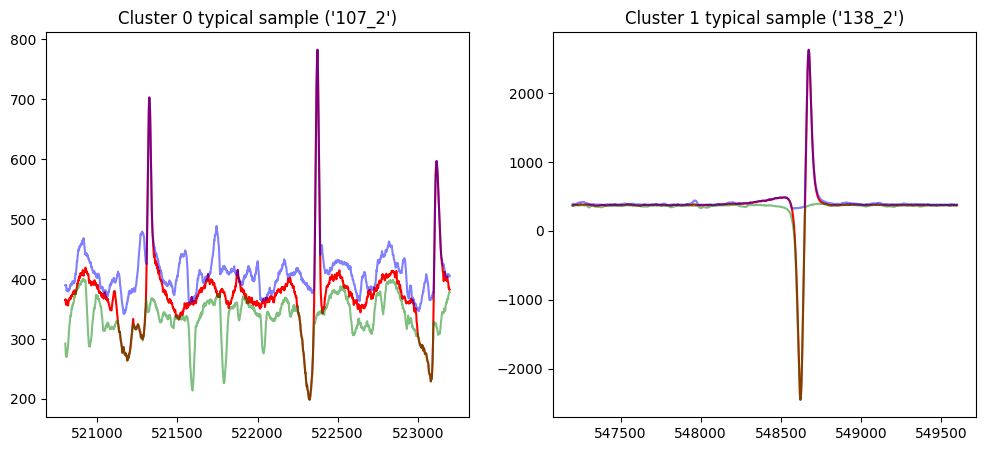

In [ ]:
# Getting table indexes of the cluster's typical samples
labels = agglo.labels_
typical = []
for cluster_id in np.unique(labels):
    cluster_points = scaled_data[labels == cluster_id]
    cluster_center = np.mean(cluster_points, axis=0)
    distances = pairwise_distances(cluster_points, [cluster_center])
    distances = distances.flatten()
    closest_index = np.argmin(distances)
    typical_sample_id = np.where(labels == cluster_id)[0][closest_index]
    typical.append(int(typical_sample_id))

# Getting legacy ID's by found indexes
table = pd.read_csv('all_data_clean_ids.csv')
sample1 = table.iloc[typical[0]]['id']
sample2 = table.iloc[typical[1]]['id']
typical_ids = [sample1, sample2]
typical_ids

# Draw typical samples by found ID's
ID = typical_ids
samples = [data[data['id']==pid] for pid in ID]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, ax in enumerate( axs.flat):
    ax.plot(samples[i]['ch0'], c='r', alpha=1, label='ch0')
    ax.plot(samples[i]['ch1'], c='g', alpha=0.5, label='ch1')
    ax.plot(samples[i]['ch2'], c='b', alpha=0.5, label='ch2')
    ax.set_title('Cluster {} typical sample (\'{}\')'.format(i,ID[i]))

# Conclusion

The following tasks have been performed in this notebook:

1) EDA with associated Feature Engineering. New dataset was built.
2) Train of a LinearSVC. F1=0.94.
3) Clustering. 2 clusters were defined, 2 related typical samples were provided.